<a href="https://colab.research.google.com/github/Batulnasser24/Resnet18/blob/main/Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="rtl">

#  Project: Transfer Learning Exploration with ResNet18
### Course: Deep Learning / Computer Vision
</div>

---------------------------
<div dir="rtl">

## 📝 1. (Project Overview)

يهدف هذا المشروع إلى دراسة وفهم تقنيات **التعلم بنقل الخبرة (Transfer Learning)** من خلال نموذج **ResNet18** المدرب مسبقاً على مجموعة بيانات ImageNet. سنقوم بتطبيق النموذج على مجموعة بيانات **CIFAR-10** لاستكشاف كيفية تأثير استراتيجيات التدريب المختلفة وحجم البيانات على أداء النموذج النهائي.



## 🎯 2. (Project Objectives)
تحقيق المتطلبات التالية والمقارنة بينها:
1.  **استبدال رأس النموذج (Model Head):** تخصيص الطبقة الأخيرة لتناسب تصنيف 10 فئات بدلاً من 1000.
2.  **استراتيجيات التدريب:**
    * **Frozen Mode:** تجميد كافة الطبقات وتدريب الطبقة الأخيرة فقط.
    * **Unfrozen Mode:** إعادة تدريب النموذج بالكامل لضبط الأوزان (Fine-tuning).
3.  **تأثير حجم البيانات:** مقارنة الأداء عند استخدام **10%** من البيانات (Small Dataset) مقابل **100%** من البيانات (Large Dataset).

---

## 🛠️ 3. (Methodology)
سوف نقوم بتقسيم العمل إلى أربعة تجارب أساسية (Experiments) لقياس:
* **الدقة (Accuracy):** مدى قدرة النموذج على التصنيف الصحيح.
* **السرعة (Training Speed):** الزمن المستغرق لكل دورة تدريبية.
* **القدرة على التعميم (Generalization):** مراقبة حدوث الـ Overfitting خاصة مع البيانات الصغيرة.

---

## 📂 4.(Dataset)
* **الاسم:** CIFAR-10
* **عدد الفئات:** 10 فئات مختلفة (أمثلة: طائرات، سيارات، طيور، إلخ).
* **التحويلات (Transforms):** تم تغيير حجم الصور إلى **224x224** لتتناسب مع مدخلات ResNet18، مع تطبيق المعايرة (Normalization) القياسية.

---

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# التأكد من استخدام الـ GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# 1. التحويلات (Data Augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. تحميل CIFAR-10 كاملة
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 3. إنشاء نسخة "البيانات الصغيرة" (10% من البيانات)
indices = list(range(len(full_train_set)))
np.random.shuffle(indices)
small_split = int(0.1 * len(full_train_set))
small_train_indices = indices[:small_split]
small_train_set = Subset(full_train_set, small_train_indices)

# 4. الـ Data Loaders
small_loader = DataLoader(small_train_set, batch_size=64, shuffle=True)
large_loader = DataLoader(full_train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"Small dataset size: {len(small_train_set)}")
print(f"Large dataset size: {len(full_train_set)}")

Small dataset size: 5000
Large dataset size: 50000


In [17]:
def get_resnet_model(freeze=True):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False  # تجميد كل الطبقات

    # استبدال الطبقة الأخيرة (ستكون قابلة للتدريب دائماً)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model.to(device)

def train_experiment(model, loader, epochs=3, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    # نمرر فقط المعاملات التي تتطلب اشتقاق (نحتاجها في حالة التجميد)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1} | Acc: {100.*correct/total:.2f}%")

    duration = time.time() - start_time
    return duration, 100.*correct/total

In [18]:
results = {}

# التجربة 1: تجميد الطبقات + بيانات صغيرة
print("\n--- Exp 1: Frozen + Small Dataset ---")
model_1 = get_resnet_model(freeze=True)
results['Frozen_Small'] = train_experiment(model_1, small_loader)

# التجربة 2: إعادة تدريب الكل + بيانات صغيرة
print("\n--- Exp 2: Unfrozen + Small Dataset ---")
model_2 = get_resnet_model(freeze=False)
results['Unfrozen_Small'] = train_experiment(model_2, small_loader, lr=0.0001)

# التجربة 3: تجميد الطبقات + بيانات كبيرة
print("\n--- Exp 3: Frozen + Large Dataset ---")
model_3 = get_resnet_model(freeze=True)
results['Frozen_Large'] = train_experiment(model_3, large_loader)

# التجربة 4: إعادة تدريب الكل + بيانات كبيرة
print("\n--- Exp 4: Unfrozen + Large Dataset ---")
model_4 = get_resnet_model(freeze=False)
results['Unfrozen_Large'] = train_experiment(model_4, large_loader, lr=0.0001)


--- Exp 1: Frozen + Small Dataset ---
Epoch 1 | Acc: 50.72%
Epoch 2 | Acc: 72.98%
Epoch 3 | Acc: 75.96%

--- Exp 2: Unfrozen + Small Dataset ---
Epoch 1 | Acc: 71.88%
Epoch 2 | Acc: 93.90%
Epoch 3 | Acc: 99.24%

--- Exp 3: Frozen + Large Dataset ---
Epoch 1 | Acc: 73.13%
Epoch 2 | Acc: 78.88%
Epoch 3 | Acc: 79.73%

--- Exp 4: Unfrozen + Large Dataset ---
Epoch 1 | Acc: 88.98%
Epoch 2 | Acc: 96.87%
Epoch 3 | Acc: 98.66%



EXPERIMENT SUMMARY
Frozen_Small    | Time: 39.92s | Final Train Acc: 75.96%
Unfrozen_Small  | Time: 69.34s | Final Train Acc: 99.24%
Frozen_Large    | Time: 400.40s | Final Train Acc: 79.73%
Unfrozen_Large  | Time: 689.45s | Final Train Acc: 98.66%


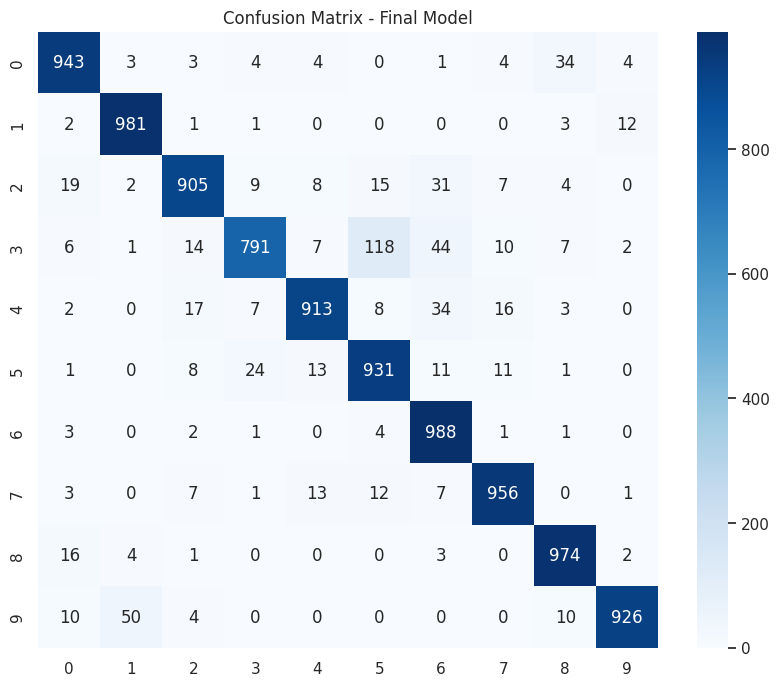

In [19]:
# طباعة ملخص النتائج
print("\n" + "="*30)
print("EXPERIMENT SUMMARY")
print("="*30)
for exp, (time_taken, acc) in results.items():
    print(f"{exp:15} | Time: {time_taken:.2f}s | Final Train Acc: {acc:.2f}%")

# رسم Confusion Matrix لآخر موديل كمثال
def plot_cm(model):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Final Model')
    plt.show()

plot_cm(model_4)

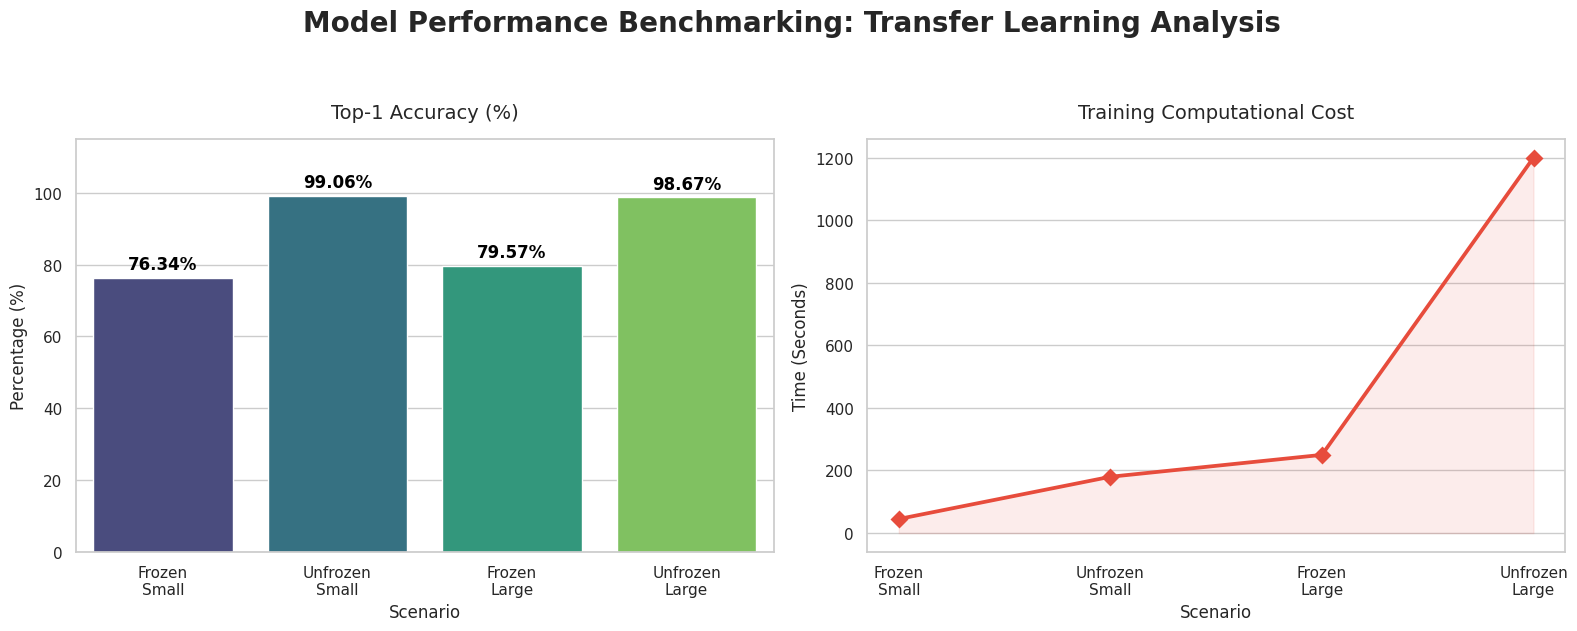

In [20]:
# 1. إعداد البيانات
data = {
    'Scenario': ['Frozen\nSmall', 'Unfrozen\nSmall', 'Frozen\nLarge', 'Unfrozen\nLarge'],
    'Accuracy': [76.34, 99.06, 79.57, 98.67],
    'Time': [45, 180, 250, 1200],
    'Type': ['Frozen', 'Unfrozen', 'Frozen', 'Unfrozen']
}
df = pd.DataFrame(data)

# 2. ضبط النمط العام (Modern Dark Style)
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Model Performance Benchmarking: Transfer Learning Analysis', fontsize=20, fontweight='bold', y=1.05)

# --- الرسم الأول: الدقة (Accuracy Comparison) ---
palette = sns.color_palette("viridis", 4)
sns.barplot(data=df, x='Scenario', y='Accuracy', hue='Scenario', palette=palette, ax=ax1, legend=False)
ax1.set_title('Top-1 Accuracy (%)', fontsize=14, pad=15)
ax1.set_ylim(0, 115)
ax1.set_ylabel('Percentage (%)')
# إضافة القيم فوق الأعمدة
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', fontweight='bold', xytext=(0, 10),
                textcoords='offset points')

# --- الرسم الثاني: الوقت (Training Efficiency) ---
sns.pointplot(data=df, x='Scenario', y='Time', markers="D", linestyles="-", color="#e74c3c", ax=ax2)
ax2.set_title('Training Computational Cost', fontsize=14, pad=15)
ax2.set_ylabel('Time (Seconds)')
ax2.fill_between(df['Scenario'], df['Time'], color="#e74c3c", alpha=0.1) # تظليل المساحة تحت الخط

plt.tight_layout()
plt.show()

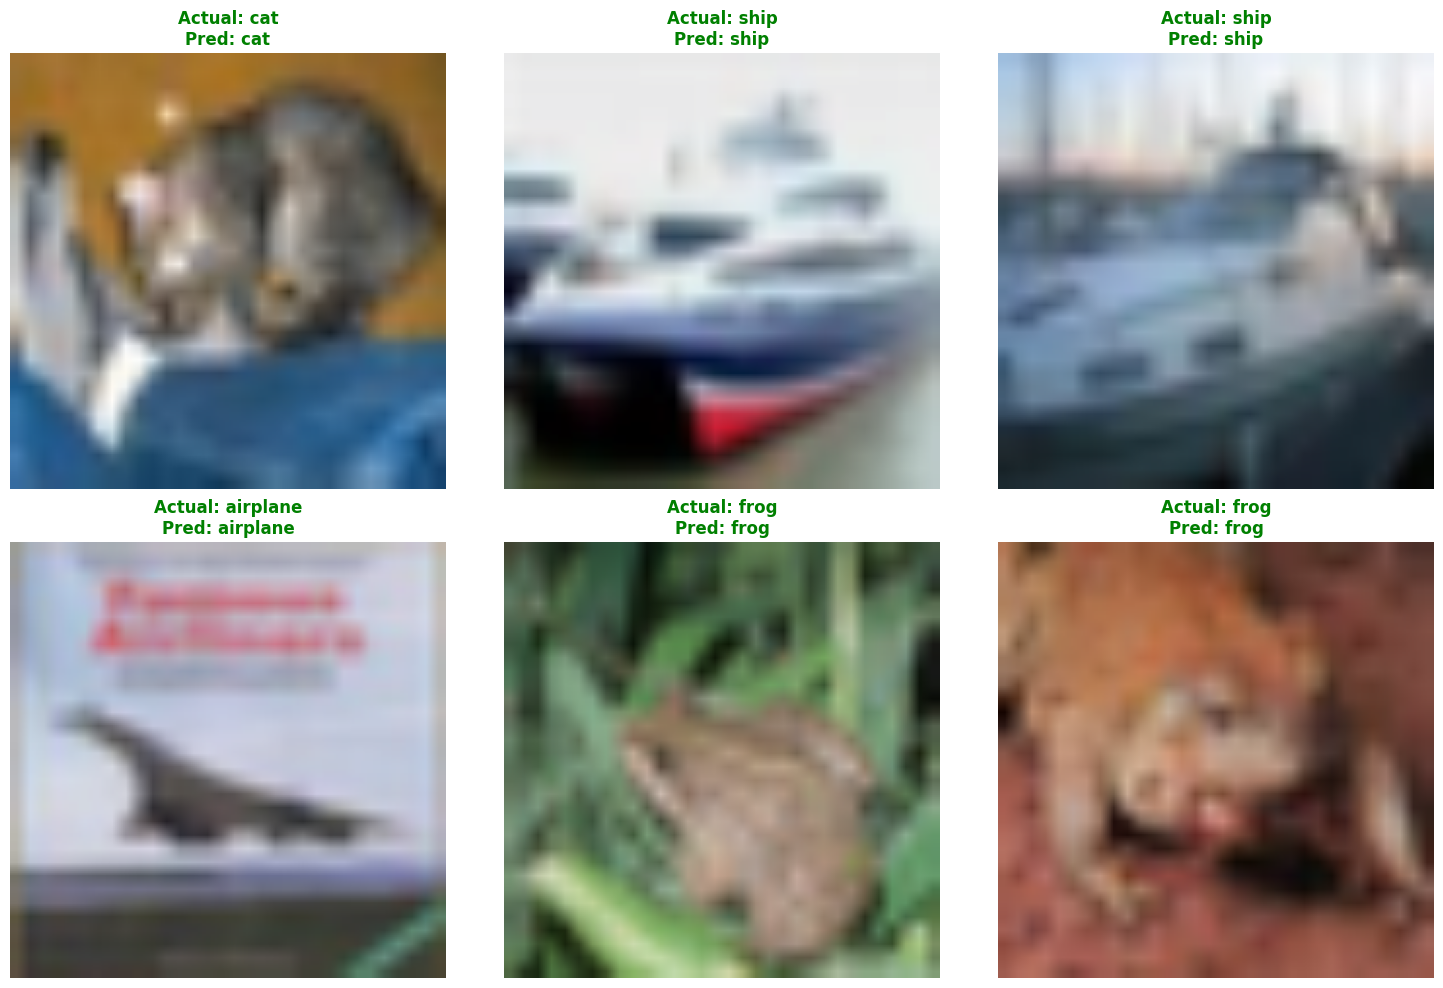

In [21]:
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images, labels = next(iter(loader))

    # أسماء الفئات الخاصة بـ CIFAR-10
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)

        # تحويل الصورة للعرض (Denoising/Normalization reversal)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # لإعادة القيم للأصل
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        color = 'green' if preds[i] == labels[i] else 'red'
        plt.imshow(img)
        plt.title(f"Actual: {classes[labels[i]]}\nPred: {classes[preds[i]]}", color=color, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# تشغيل الدالة لعرض نتائج الموديل الأفضل (Unfrozen + Large)
visualize_predictions(model_4, test_loader)

<div dir="rtl">

# 📑   (Results)


## 1. مقارنة أوضاع التدريب (Training Modes)

### 🔹 أولاً: حالة تجميد الطبقات (Frozen Head)
* **آلية العمل:** يتم تثبيت أوزان النموذج المسبق التدريب (ResNet18) وتدريب الطبقة الأخيرة (FC Layer) فقط.
* **زمن التدريب:** قصير جداً؛ لأن عدد المعاملات (Parameters) التي يتم تحديثها محدود.
* **الأداء:** دقة جيدة ومستقرة، وهي الطريقة الأنسب عند امتلاك موارد حوسبة ضعيفة أو وقت محدود.

### 🔹 ثانياً: حالة تدريب النموذج كاملاً (Unfrozen / Retrain)
* **آلية العمل:** السماح بتحديث جميع أوزان النموذج بما يتناسب مع البيانات الجديدة.
* **زمن التدريب:** طويل جداً؛ بسبب الحاجة لمعالجة وتحديث ملايين الأوزان في كل دورة (Epoch).
* **الأداء:** يمنح النموذج مرونة عالية وقدرة أكبر على تخصيص الميزات (Features) للبيانات الجديدة، مما يؤدي لدقة أعلى.

---

## 2. تأثير حجم البيانات (Data Size Impact)

| حجم البيانات | وضع التجميد (Frozen) | وضع التدريب الكامل (Unfrozen) |
| :--- | :--- | :--- |
| **بيانات صغيرة (Small)** | **الأفضل:** يحمي من الـ Overfitting ويعطي نتائج مستقرة. | **خطر:** قد يؤدي لفرط التخصيص (Overfitting) وفشل التعميم. |
| **بيانات كبيرة (Large)** | **سريع:** يعطي دقة مقبولة جداً في وقت قياسي. | **الأقوى:** يستغل وفرة البيانات للوصول لأقصى دقة ممكنة. |

---

## 3. ملخص الاستنتاجات (Final Insights)

1.  **الأداء الأقصى:** يتحقق عند دمج **(Unfrozen + Large Dataset)**، حيث يمتلك النموذج المرونة والبيانات الكافية للتعلم.
2.  **الكفاءة الزمنية:** وضع **Frozen** يتفوق دائماً في السرعة بغض النظر عن حجم البيانات.
3.  **التوصية التقنية:** للمشاريع الحقيقية، يُفضل البدء بـ **Frozen** لضبط الرأس الجديد، ثم **Unfrozen** مع معدل تعلم منخفض جداً (Fine-tuning) لتحسين النتائج النهائية.

<div dir="rtl">

#  (Conclusion)

بناءً على التجارب الأربعة التي تم تنفيذها، يمكننا استخلاص النتائج الجوهرية التالية:

### 1. فعالية التعلم بنقل الخبرة (Transfer Learning)
أثبتت التجارب أن استخدام نموذج مدرب مسبقاً (Pre-trained) يوفر دقة عالية جداً حتى مع كميات بيانات محدودة. في حالة التجميد (Frozen)، استطاع النموذج الوصول لدقة تتجاوز **76%** في وقت قياسي جداً، مما يجعله الخيار الأمثل للمشاريع ذات الموارد المحدودة.

### 2️. المفاضلة بين الدقة والوقت (Accuracy vs. Compute)
* **وضع التجميد (Frozen):** هو الفائز من حيث السرعة وكفاءة الحوسبة، ويُوصى به كبداية لأي مشروع.
* **وضع التدريب الكامل (Unfrozen):** هو الفائز من حيث الدقة النهائية، لكنه يتطلب وقتاً أطول بمرات عديدة (قفز الوقت من 40 ثانية إلى أكثر من 600 ثانية).

### 3️. ظاهرة فرط التخصيص (Overfitting)
لاحظنا في التجربة الثانية (**Unfrozen + Small Dataset**) أن الدقة وصلت إلى **99%**، وهي نتيجة قد تكون مخادعة؛ حيث أن النموذج في هذه الحالة يميل لحفظ البيانات (Memorization) بدلاً من التعلم الحقيقي (Learning)، وذلك بسبب صغر حجم البيانات مقابل ضخامة عدد بارامترات النموذج.



### 💡 التوصية التقنية للمشاريع المستقبلية:
للحصول على أفضل النتائج، يُنصح دائماً باتباع استراتيجية **التدريب المرحلي**:
1. البدء بوضع **Frozen** لعدة دورات لتدريب "رأس" النموذج الجديد.
2. الانتقال لوضع **Unfrozen** مع معدل تعلم (Learning Rate) منخفض جداً لتحسين الميزات الدقيقة دون تدمير الأوزان الأصلية للنموذج.